<a href="https://colab.research.google.com/github/pallamadhavi/PAMI/blob/main/notebooks/sequencePatternMining/basic/prefixSpan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding frequent sequential patterns in sequence databases using prefixSpan

This tutorial has two parts. In the first part, we describe the basic approach to find frequent patterns in a sequence database using the prefixSpan algorithm. In the final part, we describe an advanced approach, where we evaluate the prefixSpan algorithm on a dataset at different *minimum support* threshold.

## Prerequisites:

1. Installing the PAMI library

In [1]:
!pip install -U pami

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.6/884.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 13.4 MB/s eta 0:00:00
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3313 sha256=24f1ed9be33fd1ed8fc41dd2caf57e0cb08ec766f341eaf8c4c90382b0fcc91e
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4753 sha256=a8dd07feffdb5db4316575fece7ff4b73e6cb757aeaa95920fc5dfb8aeef444d
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully built JsonForm JsonSir


2. Downloading a sample dataset

In [2]:
!wget -nc https://www.dropbox.com/scl/fi/c2xdmns7rprxnkgd9h3gb/airPollution.csv?rlkey=q7zoop7mi2n4z3qi94lpc1jlf&dl=0

--2023-11-21 07:30:01--  https://www.dropbox.com/scl/fi/c2xdmns7rprxnkgd9h3gb/airPollution.csv?rlkey=q7zoop7mi2n4z3qi94lpc1jlf
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0f6fc9da65edd4e50ccf7c1239.dl.dropboxusercontent.com/cd/0/inline/CH_pZrItIDYbZ9UTzu3Ti4pZ4Wyc4xkmJLhsiQ76BOz3uhXivthBAnKKjpfd-yUe1aPRLDl85sEAzbO2CyN8dyzQlSsG1_CpFqBQ9iJGLZsi8M3ccuY8RNEysHIF9qdWVpJbDHnzSfSI6ytB0GIgLxfp/file# [following]
--2023-11-21 07:30:02--  https://uc0f6fc9da65edd4e50ccf7c1239.dl.dropboxusercontent.com/cd/0/inline/CH_pZrItIDYbZ9UTzu3Ti4pZ4Wyc4xkmJLhsiQ76BOz3uhXivthBAnKKjpfd-yUe1aPRLDl85sEAzbO2CyN8dyzQlSsG1_CpFqBQ9iJGLZsi8M3ccuY8RNEysHIF9qdWVpJbDHnzSfSI6ytB0GIgLxfp/file
Resolving uc0f6fc9da65edd4e50ccf7c1239.dl.dropboxusercontent.com (uc0f6fc9da65edd4e50ccf7c1239.dl.dropboxusercontent.com)... 162.125.80.15,

3 convert air pollution dataset to sequence dataset

3.1 change filename to airPollution.csv

In [3]:
!mv airPollution.csv?rlkey=q7zoop7mi2n4z3qi94lpc1jlf airPollution.csv

3.2 show the first 3 row as example of database

In [4]:
!head -3 airPollution.csv

,TimeStamp,POINT(137.2331301 36.7425277),POINT(140.8733429 38.2932172),POINT(139.1103334 36.2974922),POINT(140.957261 37.6422006),POINT(139.2619009 36.0594871),POINT(135.5188107 34.7919888),POINT(141.7627117 40.1916885),POINT(140.7468006 41.8188869),POINT(139.7422865 36.2305774),POINT(133.9318657 34.4600964),POINT(139.993363 35.6771308),POINT(140.5346664 36.3965854),POINT(139.9382318 35.374032),POINT(140.138552 35.611391),POINT(139.0960211 36.4047323),POINT(135.7079001 34.6916695),POINT(139.3678037 35.4666052),POINT(134.2940462 34.7473902),POINT(140.1460666 35.3335387),POINT(135.0986062 34.6935289),POINT(139.7638423 35.93410739999999),POINT(136.8127001 35.1404408),POINT(135.790301 34.509211),POINT(139.3908038 35.446427),POINT(133.7758944 34.6007931),POINT(139.6624281 35.4151966),POINT(140.4021967 36.555081),POINT(138.5998848 35.1758502),POINT(130.601994 32.507843),POINT(132.2165637 34.1698473),POINT(139.466145 35.4718748),POINT(137.7915988 34.7918944),POINT(138.9138437 36.323256),POINT

3.3 read file as dataset

In [5]:
import pandas as pd
dataset = pd.read_csv('airPollution.csv', index_col="TimeStamp")

dataset
# you can notice that dataset is collected from 2018-01-01 01:00:00 hours to 2023-04-25 22:00:00 hours (5+ years)

,Unnamed: 0,POINT(137.2331301 36.7425277),POINT(140.8733429 38.2932172),POINT(139.1103334 36.2974922),POINT(140.957261 37.6422006),POINT(139.2619009 36.0594871),POINT(135.5188107 34.7919888),POINT(141.7627117 40.1916885),POINT(140.7468006 41.8188869),POINT(139.7422865 36.2305774),...,POINT(139.6184164 35.402381),POINT(133.7693672 34.5091621),POINT(134.5801986 34.90361180000001),POINT(130.9395423 33.8302551),POINT(141.6892571 42.6698527),POINT(130.3518793 32.088342),POINT(141.6309688 42.6576551),POINT(138.4066959 34.9960412),POINT(140.0499266 39.3839601),POINT(130.4674218 32.9808242)
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2021-07-01 01:00:00,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,NaN,NaN,1.0,14.0,4.0,NaN,8.0,5.0,23.0
2021-07-01 02:00:00,1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,NaN,NaN,1.0,5.0,5.0,NaN,6.0,4.0,18.0
2021-07-01 03:00:00,2,4.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,...,NaN,NaN,NaN,2.0,4.0,3.0,NaN,6.0,4.0,9.0
2021-07-01 04:00:00,3,11.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,...,7.0,NaN,NaN,3.0,1.0,4.0,NaN,2.0,5.0,1.0
2021-07-01 05:00:00,4,10.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,8.0,NaN,NaN,3.0,2.0,4.0,NaN,3.0,5.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-24 18:00:00,3521,7.0,NaN,NaN,NaN,12.0,NaN,2.0,NaN,NaN,...,11.0,NaN,NaN,20.0,3.0,11.0,NaN,7.0,9.0,12.0
2022-07-24 19:00:00,3522,8.0,NaN,NaN,NaN,10.0,NaN,2.0,NaN,NaN,...,4.0,NaN,NaN,18.0,34.0,10.0,NaN,8.0,8.0,11.0
2022-07-24 20:00:00,3523,4.0,NaN,NaN,NaN,9.0,NaN,4.0,NaN,NaN,...,9.0,NaN,NaN,25.0,1.0,10.0,NaN,6.0,705.0,14.0


3.4 fill NAN value to 0

In [6]:
dataset = dataset.fillna(0)
dataset.head()

,Unnamed: 0,POINT(137.2331301 36.7425277),POINT(140.8733429 38.2932172),POINT(139.1103334 36.2974922),POINT(140.957261 37.6422006),POINT(139.2619009 36.0594871),POINT(135.5188107 34.7919888),POINT(141.7627117 40.1916885),POINT(140.7468006 41.8188869),POINT(139.7422865 36.2305774),...,POINT(139.6184164 35.402381),POINT(133.7693672 34.5091621),POINT(134.5801986 34.90361180000001),POINT(130.9395423 33.8302551),POINT(141.6892571 42.6698527),POINT(130.3518793 32.088342),POINT(141.6309688 42.6576551),POINT(138.4066959 34.9960412),POINT(140.0499266 39.3839601),POINT(130.4674218 32.9808242)
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2021-07-01 01:00:00,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,0.0,1.0,14.0,4.0,0.0,8.0,5.0,23.0
2021-07-01 02:00:00,1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,0.0,1.0,5.0,5.0,0.0,6.0,4.0,18.0
2021-07-01 03:00:00,2,4.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,2.0,4.0,3.0,0.0,6.0,4.0,9.0
2021-07-01 04:00:00,3,11.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,7.0,0.0,0.0,3.0,1.0,4.0,0.0,2.0,5.0,1.0
2021-07-01 05:00:00,4,10.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,8.0,0.0,0.0,3.0,2.0,4.0,0.0,3.0,5.0,6.0


3.5 convert the database sequential database and save it in "airDatabase.txt"

In [7]:
class convertDenseDataframe2SequenceDatabase:

  seq=[]
  def __init__(self,df,minScore):

      hour=0
      row=[]
      last=str(0000)
      for i in df.index:
          if last!=i[6:10] and row!=[]:
              row.append(-2)
              self.seq.append(row)
              row=[]
          last=i[6:10]
          for k in df.columns[1:]:
              if k != "TimeStamp":
                  if df.loc[i,k]>=minScore:
                      row.append(k)
          if row!=[] and row[-1]!=-1:
              row.append(-1)
      row.append(-2)
      self.seq.append(row)

  def getSequence(self):
    return self.seq

  def save(self,outputFileName):
        with open(outputFileName, 'w') as f:
            for d in self.seq:
                for i in d:
                    p=str(i).replace(" ",",")
                    f.write("%s\t" % p)
                f.write("\n")

In [8]:
dataset = pd.read_csv('airPollution.csv',index_col="TimeStamp")
x=convertDenseDataframe2SequenceDatabase(dataset,15)
seq=x.getSequence()
x.save("airDatabase.txt")


4 Printing few lines of a dataset to know its format.

4.1 sequential dataset

In [9]:
!head -2 airDatabase.txt

POINT(130.601994,32.507843)	POINT(132.2165637,34.1698473)	POINT(136.6548337,35.0051925)	POINT(130.2113464,32.7321302)	POINT(132.7326196,33.8884275)	POINT(130.3597423,33.5840497)	POINT(130.4105582,33.6051041)	POINT(132.7283802,33.8225127)	POINT(140.1138229,37.919914)	POINT(130.4674218,32.9808242)	-1	POINT(130.601994,32.507843)	POINT(132.2165637,34.1698473)	POINT(132.7326196,33.8884275)	POINT(130.3597423,33.5840497)	POINT(136.603013,36.598011)	POINT(130.4105582,33.6051041)	POINT(132.7283802,33.8225127)	POINT(130.4674218,32.9808242)	-1	POINT(130.601994,32.507843)	POINT(132.2165637,34.1698473)	POINT(130.3597423,33.5840497)	POINT(132.7283802,33.8225127)	-1	POINT(130.601994,32.507843)	POINT(136.6548337,35.0051925)	POINT(130.3597423,33.5840497)	POINT(132.7283802,33.8225127)	-1	POINT(130.601994,32.507843)	POINT(140.1138229,37.919914)	-1	POINT(130.601994,32.507843)	POINT(141.6892571,42.6698527)	-1	POINT(136.603013,36.598011)	-1	POINT(136.603013,36.598011)	-1	POINT(136.6548337,35.0051925)	POINT(

_format:_ every row contains items seperated by a seperator in one sequence.
        _ every row contains subsequence seperated by a "-1".
        _ every row contains sequence seperated by a "-2".

__Example:__

item1 item2 -1 item3 item4 -1 -2

item1 item4 -1 item6 -1 -2

## Part 1: Finding frequent sequential patterns using prefixSpan

### Step 1: Understanding the statistics of a sequence database

In [10]:
#import the class file
from PAMI.extras.dbStats import SequentialDatabase as stats

#specify the file name
inputFile = 'airDatabase.txt'

#initialize the class
obj=stats.SequentialDatabase(inputFile,sep='\t')

#execute the class
obj.readDatabase()

##Step 2: Draw the items' frequency graph and sequence length's distribution graphs for more information

In [11]:
obj.printStats()

Database size (total no of sequence) : 135
Number of items : 121
Minimum Sequence Size : 1
Average Sequence Size : 20.955555555555556
Maximum Sequence Size : 24
Standard Deviation Sequence Size : 6.568010766746562
Variance in Sequence Sizes : 43.460696517412934
Sequence size (total no of subsequence) : 2829
Minimum subSequence Size : 1
Average subSequence Size : 18.83457051961824
Maximum subSequence Size : 104
Standard Deviation Sequence Size : 18.84802364721196
Variance in Sequence Sizes : 355.37361350890427


### Step 3: Choosing an appropriate *minSup* value

In [12]:
minSup= 0.4 #minSup is specified in count. However, the users can also specify minSup between 0 and 1.

### Step 4:Mining frequent sequence patterns using prefixSpan

In [13]:
from PAMI.sequentialPatternMining.basic import prefixSpan as alg


_ap = alg.prefixSpan('airDatabase.txt', minSup, '\t')
_ap.mine()
_Patterns = _ap.getPatterns()
_memUSS = _ap.getMemoryUSS()
print("Total Memory in USS:", _memUSS)
_memRSS = _ap.getMemoryRSS()
print("Total Memory in RSS", _memRSS)
_run = _ap.getRuntime()
print("Total ExecutionTime in ms:", _run)
print("Total number of Frequent Patterns:", len(_Patterns))
_ap.save("results.txt")

Frequent patterns were generated successfully using prefixSpan algorithm 
Total Memory in USS: 281456640
Total Memory in RSS 304390144
Total ExecutionTime in ms: 283.3099434375763
Total number of Frequent Patterns: 131263


Step 5: Investigating the generated patterns
Open the patterns' file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different minSup value.

In [14]:
!head results.txt

['POINT(130.2113464,32.7321302)', -1]:57 
['POINT(130.2113464,32.7321302)', -1, 'POINT(130.4674218,32.9808242)', -1]:54 
['POINT(130.2113464,32.7321302)', -1, 'POINT(130.601994,32.507843)', -1]:54 
['POINT(130.2113464,32.7321302)', -1, 'POINT(132.7326196,33.8884275)', -1]:56 
['POINT(130.2113464,32.7321302)', -1, 'POINT(132.7326196,33.8884275)', -1, 'POINT(136.6548337,35.0051925)', -1]:56 
['POINT(130.2113464,32.7321302)', -1, 'POINT(136.6548337,35.0051925)', -1]:56 
['POINT(130.2113464,32.7321302)', -1, 'POINT(136.6548337,35.0051925)', -1, 'POINT(136.6548337,35.0051925)', -1]:55 
['POINT(130.2113464,32.7321302)', -1, 'POINT(136.6548337,35.0051925)', -1, 'POINT(132.7326196,33.8884275)', -1]:55 
['POINT(130.2113464,32.7321302)', -1, 'POINT(130.9612121,33.8854016)', -1]:54 
['POINT(130.3597423,33.5840497)', -1]:54 


The storage format is: _frequentPattern:support_

## Part 2: Evaluating the prefixSpan algorithm on a dataset at different minSup values

### Step 1: Import the libraries and specify the input parameters

In [15]:
#Import the libraries
from PAMI.sequentialPatternMining.basic import prefixSpan as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = "airDatabase.txt"
seperator='\t'
minimumSupportCountList = [0.4,0.42,0.44,0.46,0.48,0.5]
#minimumSupport can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

In [16]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of prefixSpan algorithm

In [17]:
for minSupCount in minimumSupportCountList:
    obj = alg.prefixSpan(inputFile, minSup=minSupCount,sep=seperator)
    obj.mine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['prefixSpan', minSupCount, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

Frequent patterns were generated successfully using prefixSpan algorithm 
Frequent patterns were generated successfully using prefixSpan algorithm 
Frequent patterns were generated successfully using prefixSpan algorithm 
Frequent patterns were generated successfully using prefixSpan algorithm 
Frequent patterns were generated successfully using prefixSpan algorithm 
Frequent patterns were generated successfully using prefixSpan algorithm 


In [20]:
print(result)

    algorithm  minSup  patterns     runtime     memory
0  prefixSpan    0.40    131263  281.693866  351698944
1  prefixSpan    0.42     65522  157.398347  332500992
2  prefixSpan    0.44     34350   90.421109  329404416
3  prefixSpan    0.46     18587   47.064498  327340032
4  prefixSpan    0.48     12596   33.374523  326307840
5  prefixSpan    0.50      7264   19.613495  326307840


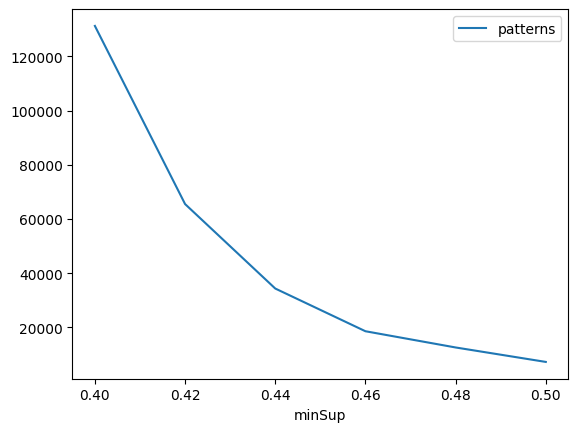

Graph for No Of Patterns is successfully generated!


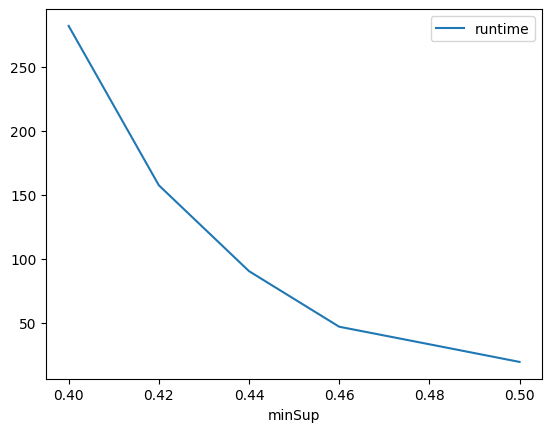

Graph for Runtime taken is successfully generated!


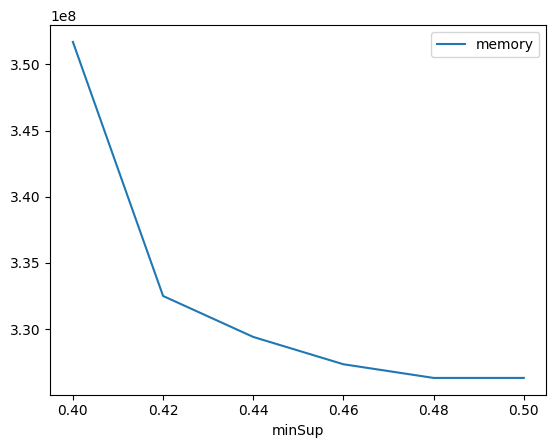

Graph for memory consumption is successfully generated!


In [19]:
from PAMI.extras.graph import plotLineGraphsFromDataFrame as plt

ab = plt.plotGraphsFromDataFrame(result)
ab.plotGraphsFromDataFrame()